# CH4 Time Series Preprocessing and EDA
**Purpose**: Prepare methane (CH4) data for forecasting using `GasPreprocessor`  

## Workflow  
1. Load cleaned GHG data  
2. Initialize preprocessor  
3. Fit/transform CH4 series  
4. Save processed data  

**Input**: `data/processed/all_ghg_aligned_nan.csv`  
**Output**: `data/processed/ch4_preprocessed.csv`  

[View GasPreprocessor docs](../src/preprocessing.py)  

**Note**: The identical preprocessing will be reapplied to the training set in `4_ch4_modeling.ipynb`  
to avoid data leakage. This full-dataset version is for exploratory purposes only.

In [1]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

from src.preprocessing import GasPreprocessor
print('GasPreprocessor imported sucessfully!')

GasPreprocessor imported sucessfully!


# Load datasets

In [3]:
# load cleaned data (with negative values --> NaN)
df = pd.read_csv(
    '../data/processed/all_ghg_aligned_nan.csv',
    parse_dates=['date'],
    dtype={'CH4': float}
)

print(f'loaded {len(df)} records')
display(df.head())

loaded 2562 records


,date,CH4,CO,CO2,H2,N2O,SF6
0,1969-08-20,NaN,NaN,-5.2700,NaN,NaN,NaN
1,1969-08-27,NaN,NaN,-2.1625,NaN,NaN,NaN
2,1969-09-02,NaN,NaN,-9.1150,NaN,NaN,NaN
3,1969-09-12,NaN,NaN,320.9450,NaN,NaN,NaN
4,1969-09-24,NaN,NaN,320.8900,NaN,NaN,NaN


In [4]:
# Check input data before calling fit_transform
print(f"Input data shape: {df[['date', 'CH4']].shape}")
print(f"NaN values in CH4: {df['CH4'].isna().sum()}")
print(f"Negative values in CH4: {(df['CH4'] < 0).sum()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Input data shape: (2562, 2)
NaN values in CH4: 439
Negative values in CH4: 1
Date range: 1969-08-20 00:00:00 to 2025-04-03 00:00:00


# Initialize Preprocessor class

In [5]:
# configure for weekly CH4 data with yearly seasonality
preprocessor = GasPreprocessor(
    gas_name='CH4',
    do_eda=True,
    iqr_factor=3.0
)

## CH4 Preprocessing and EDA


[INFO] Fitting preprocessing for CH4

Trimming 388 leading NaN values

Trimming 8 trailing NaN values
Raw data: 2562 points, 439 NaNs
Trimmed data: 2166 points, 43 NaNs
Data range after trimming: 1983-05-06 00:00:00 to 2024-12-31 00:00:00
After resampling: 2175 points, 78 NaNs
[INFO] Found 42 potential outliers using robust STL residuals.
After outlier removal: 2175 points, 120 NaNs
After smoothing: 2175 points, 0 NaNs
After interpolation: 2175 points, 0 NaNs


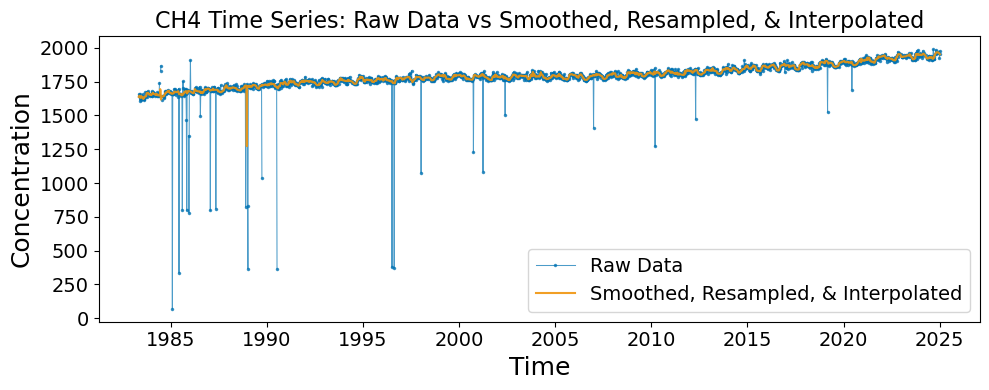

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.8459
ADF p-value 0.8053
ADF critical values: {'1%': -3.4333923407704177, '5%': -2.8628839944786275, '10%': -2.567485476439311}

KPSS statistic 6.9187
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:423: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


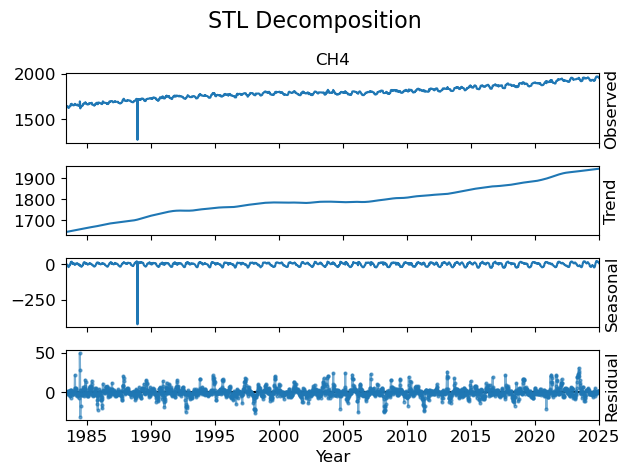

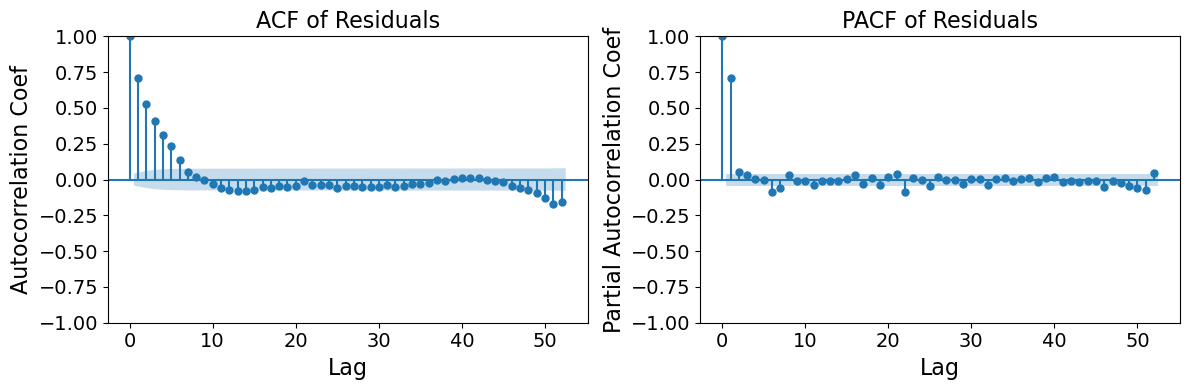


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.6075
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.4826
No heteroscedasticity detected (White test)

Trimming 388 leading NaN values

Trimming 8 trailing NaN values


date
1983-05-08    1637.32925
1983-05-15    1645.17000
1983-05-22    1645.17000
1983-05-29    1637.32925
1983-06-05    1630.24525
Freq: W-SUN, Name: CH4, dtype: float64

In [6]:
# Run full preprocessing pipeline
ch4_preprocessed = preprocessor.fit_transform(
    df[['date', 'CH4']],
    custom_title='CH4 Time Series: Raw Data vs Smoothed, Resampled, & Interpolated'
)

# Show results
display(ch4_preprocessed.head())
plt.show()

# Determine if Seasonal Cycles are Addititive or Multiplicative

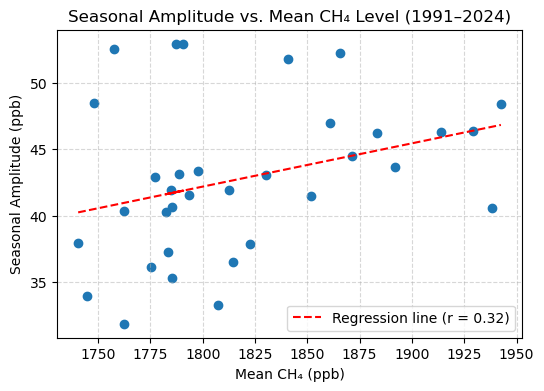

In [37]:
# plot amplitude of the seasonal cycle vs mean CH4 concentration.  
# if the seasonal cycles do not scale with the long term mean, then the cycles are additive
# if the seasonal cycles scale with the mean, then the cycles are multiplicative 

# mask the first few years of data due to the large spikes that exist prior to 1990
mask = (ch4_preprocessed.index >= '1991-01-01') & (ch4_preprocessed.index <= '2024-12-31')
ch4_subset = ch4_preprocessed[mask]

df = ch4_subset.to_frame(name='CH4')
df['year'] = df.index.year

# Group by year to compute mean and amplitude
yearly = df.groupby('year')['CH4'].agg(['mean', 'max', 'min'])
yearly['amplitude'] = yearly['max'] - yearly['min']

# calculate the regression line
x = yearly['mean'].values
y = yearly['amplitude'].values
m, b = np.polyfit(x, y, 1)

# Scatter plot: mean vs amplitude
plt.figure(figsize=(6,4))
plt.scatter(yearly['mean'], yearly['amplitude'])
plt.plot(x, m*x + b, color='red', linestyle='--', label=f'Regression line (r = {corr:.2f})')
plt.xlabel('Mean CH₄ (ppb)')
plt.ylabel('Seasonal Amplitude (ppb)')
plt.title('Seasonal Amplitude vs. Mean CH₄ Level (1991–2024)')

# Correlation check
corr = yearly['mean'].corr(yearly['amplitude'])

# plt.plot(corr)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

**Interpretation:**

- r = 0:  additive (seasonal amplitude does not scale with concentration mean)
- r = 0.3-0.5: likely multiplicative (mild scaling of seasonal amplitude with the concentration mean)
- r > 0.6: muliplicative (strong scaling)

So, the data is trend dominant and weakly multiplicative, suggesting that it will likely benefit from log transformation

## CH4 Preprocessing Results Summary

### **Preprocessing**
The preprocessing pipeline successfully handled outliers and missing (NaN) values while remaining consistent with the original time series characteristics.  

### **Stationarity Analysis**
All processing stages (raw --> smoothed --> resampled) show consistent non-stationarity:
- **ADF Test**: Fails to reject H0 (p > 0.05)  
- **KPSS Test**: Rejects H0 (p < 0.05)  
*Interpretation*: Strong trend dominance persists through preprocessing, which is expected and appropriate.  Differencing to achieve stationarity will be handled during SARIMA model specification.  

### **STL Decomposition Insights**
Analysis of the STL decomposition residuals indicates homoscedastic variance:
- **Breusch-Pagan test**: No heteroscedasticity detected (p = 0.61)
- **White test**: No heteroscedasticity detected (p = 0.48)
  
Constant variance in residuals is an optimal characteristic for SARIMA modeling.  

However, the seasonal amplitude vs mean CH4 concentration reveals mild multiplicative tendency (r = 0.32).  So, log transformation may still be effective for stabilizing variance for modeling wiith SARIMA.  
  
### **Autocorrelation Diagnostics**
- **ACF of Residuals**:  
  - Slow decay in ACF suggests an autoregressive (AR) component 
  - Significant lags at 1-5, potentially indicating an MA(5) process (MA = moving average)  
  - Spike at lag 52 suggests residual seasonality that may require seasonal AR or MA terms
- **PACF of Residuals**:  
  - Sharp cutoff after lag 1 suggests a strong AR(1) process 

### **Key Implications for Modeling**
1. Required transformations:  
   - **Differencing**: First order differencing will be necessary to address persistent (upward) trend
   - **Seasonal adjustment**: Seasonal terms (likely period 52) should be incorporated to capture remaining seasonal pattern
2. Initial model specification:  
   - ARIMA(1,1,5) as starting point  
   - Seasonal periodicity: 52 weeks  
3. Variance stability:
   - The homoscedastic residuals suggest that variance-stabilizing transformations may not be necessary

# Save Preprocessed CH4 Data

In [ ]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

# save metadata
output_path = output_dir / 'ch4_preprocessed.csv'
(
    ch4_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4 preprocessed data saved to:\n{output_path}')
print(f'Shape: {ch4_preprocessed.shape}\nLast 5 records:')
display(ch4_preprocessed.tail())